<h2 align=center>Annotated Corpus for Named Entity Recognition(NER) using LSTMs with Keras</h2>

### Import Modules

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.3.0
GPU detected: []


### Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [8]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [9]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [10]:
words = list(set(data["Word"].values))# All words as a list
words.append("ENDPAD") # End of sentence
num_words = len(words)

In [11]:
tags = list(set(data["Tag"].values)) # All the tag as list
num_tags = len(tags)

Retrieve Sentences and Corresponsing Tags

In [12]:
# Coverting a sentence as a list of tuples where w: Word, p :Pos and t:tag.
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [13]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [14]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Define Mappings between Sentences and Tags

In [15]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [16]:
word2idx

{'Petra': 1,
 'electrical': 2,
 'Taraba': 3,
 'RENE': 4,
 'November': 5,
 '1,500': 6,
 'Viktor': 7,
 'bagpipes': 8,
 'defying': 9,
 '\x96': 10,
 'Dance': 11,
 'Compay': 12,
 'Jamia': 13,
 'born': 14,
 'recalled': 15,
 'UTC': 16,
 'Thapa': 17,
 'respected': 18,
 'excluded': 19,
 'self-proclaimed': 20,
 'certified': 21,
 'hepatitis': 22,
 'Napoleonic': 23,
 'Soviet-backed': 24,
 'Univision': 25,
 'best-known': 26,
 'Equality': 27,
 'Endless': 28,
 'females': 29,
 'displeased': 30,
 'superabundant': 31,
 'Costan': 32,
 'accessed': 33,
 'terror': 34,
 'Yu': 35,
 'hero': 36,
 'Khanun': 37,
 'Present': 38,
 'Addis': 39,
 'helps': 40,
 'wed': 41,
 'Amorim': 42,
 'holdings': 43,
 'Hemisphere': 44,
 'Gamsakhurdia': 45,
 'succeed': 46,
 'protective': 47,
 'Interlagos': 48,
 'Marjayoun': 49,
 'Edition': 50,
 'Vassily': 51,
 'Veerman': 52,
 'prospering': 53,
 'Qilla': 54,
 'al-Otari': 55,
 'mascots': 56,
 'forgiven': 57,
 'AP': 58,
 'vestige': 59,
 'humaneness': 60,
 'Weaver': 61,
 'Auriol': 62,
 

Padding Input Sentences and Creating Train/Test Splits

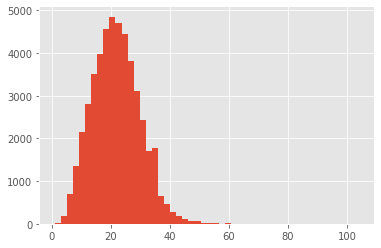

In [17]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Build and Compile a Bidirectional LSTM Model

In [20]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [21]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### Train the Model

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras

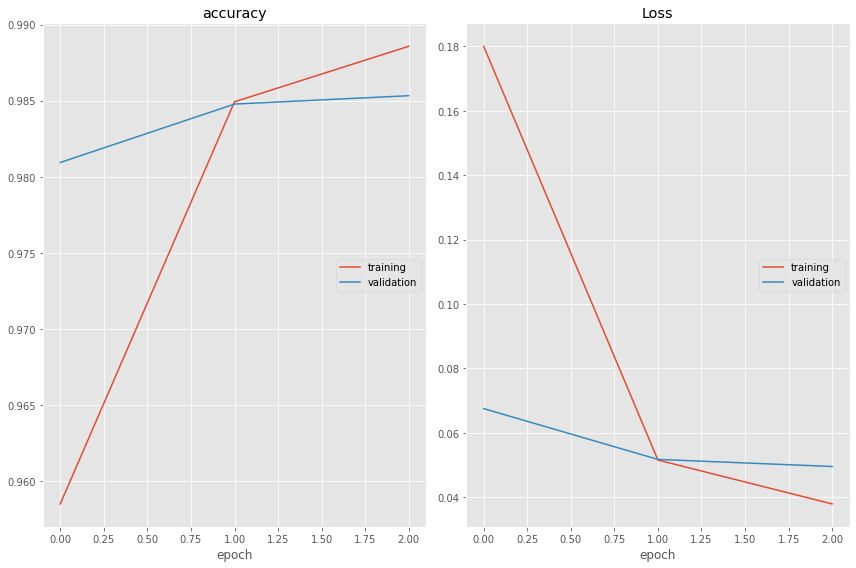

accuracy
	training         	 (min:    0.958, max:    0.989, cur:    0.989)
	validation       	 (min:    0.981, max:    0.985, cur:    0.985)
Loss
	training         	 (min:    0.038, max:    0.180, cur:    0.038)
	validation       	 (min:    0.050, max:    0.068, cur:    0.050)
1199/1199 [==============================] - 122s 102ms/step - loss: 0.0380 - accuracy: 0.9886 - val_loss: 0.0496 - val_accuracy: 0.9853
Wall time: 6min 4s


In [24]:
%%time

# chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesKeras(),  early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

### Evaluate Named Entity Recognition Model

In [25]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 4s 13ms/step - loss: 0.0496 - accuracy: 0.9853


[0.04958663135766983, 0.9853273630142212]

In [27]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
The            O	O
Israeli        B-gpe	B-gpe
parliament     O	O
has            O	O
rejected       O	O
a              O	O
bill           O	O
calling        O	O
for            O	O
a              O	O
national       O	O
referendum     O	O
on             O	O
Prime          B-per	B-per
Minister       I-per	I-per
Ariel          I-per	I-per
Sharon         I-per	I-per
's             O	O
plan           O	O
to             O	O
evacuate       O	O
settlers       O	O
and            O	O
troops         O	O
from           O	O
the            O	O
Gaza           B-geo	B-geo
Strip          I-geo	I-geo
and            O	O
four           O	O
small          O	O
West           B-org	B-org
Bank           I-org	I-org
enclaves       I-org	O
later          O	B-tim
this           O	O
year           O	O
.              O	O
facilitation   O	O
facilitation   O	O
facilitation   O	O
facilitation   O	O
facilitation   O	O
facilitation   O	O
facilitation   O	O
facili

In [29]:
tf.saved_model.save(model,"Named_Entity_Recognition/")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Named_Entity_Recognition/assets


In [37]:
test1 = "alex is from china and working in military"

In [40]:
y_test[1]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 10,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [34]:
test1 = np.array(test1)

In [36]:
test1

array('alex is from china and working in military', dtype='<U42')